In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import warnings
warnings.filterwarnings('ignore')

In [226]:
Data = yf.download('googl')

[*********************100%%**********************]  1 of 1 completed


In [227]:
Data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08-19,2.502503,2.604104,2.401401,2.511011,2.511011,893181924
2004-08-20,2.527778,2.729730,2.515015,2.710460,2.710460,456686856
2004-08-23,2.771522,2.839840,2.728979,2.737738,2.737738,365122512
2004-08-24,2.783784,2.792793,2.591842,2.624374,2.624374,304946748
2004-08-25,2.626627,2.702703,2.599600,2.652653,2.652653,183772044
...,...,...,...,...,...,...
2023-10-25,128.160004,128.309998,125.070000,125.610001,125.610001,84366200
2023-10-26,123.269997,124.330002,121.269997,122.279999,122.279999,57061100
2023-10-27,122.879997,123.309998,120.209999,122.169998,122.169998,44531100


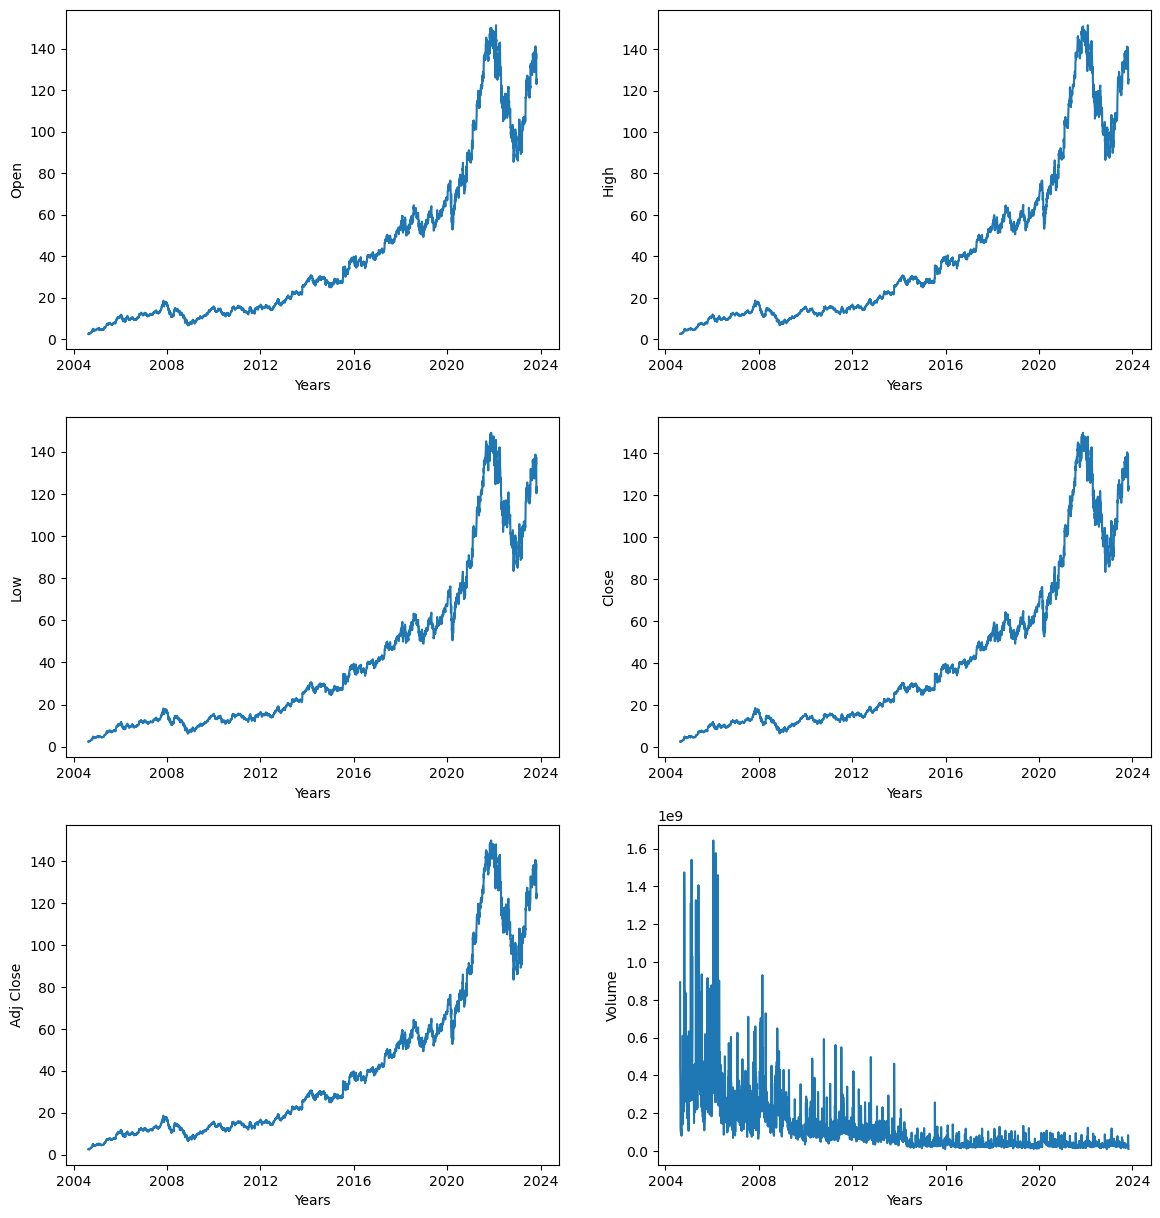

In [228]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize = (14, 15))
for ind, col in enumerate(Data.columns):
    ax[ind//2, ind%2].plot(Data.index, Data[col])
    ax[ind//2, ind%2].set_xlabel('Years')
    ax[ind//2, ind%2].set_ylabel(col)

In [229]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4834 entries, 2004-08-19 to 2023-10-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       4834 non-null   float64
 1   High       4834 non-null   float64
 2   Low        4834 non-null   float64
 3   Close      4834 non-null   float64
 4   Adj Close  4834 non-null   float64
 5   Volume     4834 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 264.4 KB


In [230]:
(Data.Close != Data['Adj Close']).sum()

0

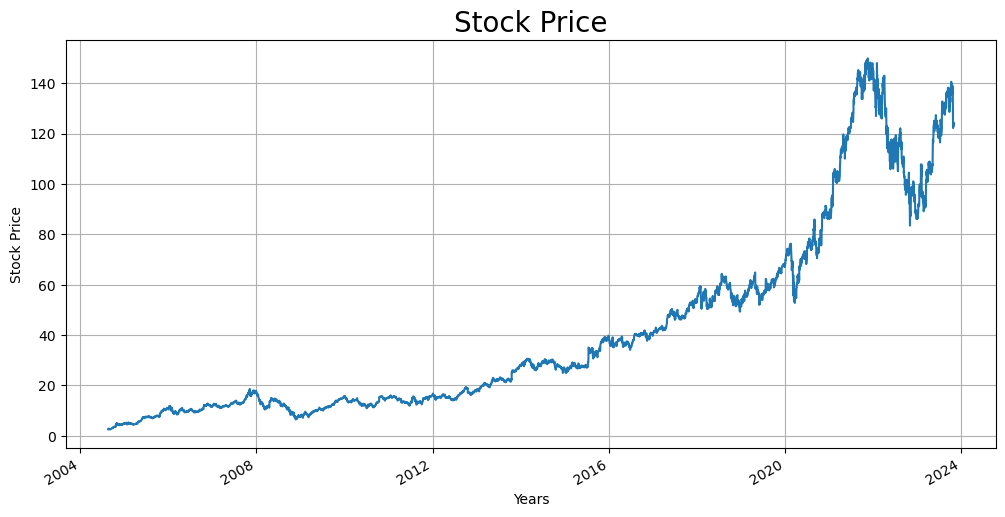

In [231]:
Data.Close.plot(figsize=(12, 6))
plt.title('Stock Price', fontsize=20)
plt.xlabel('Years')
plt.ylabel('Stock Price')
plt.grid()
plt.show()

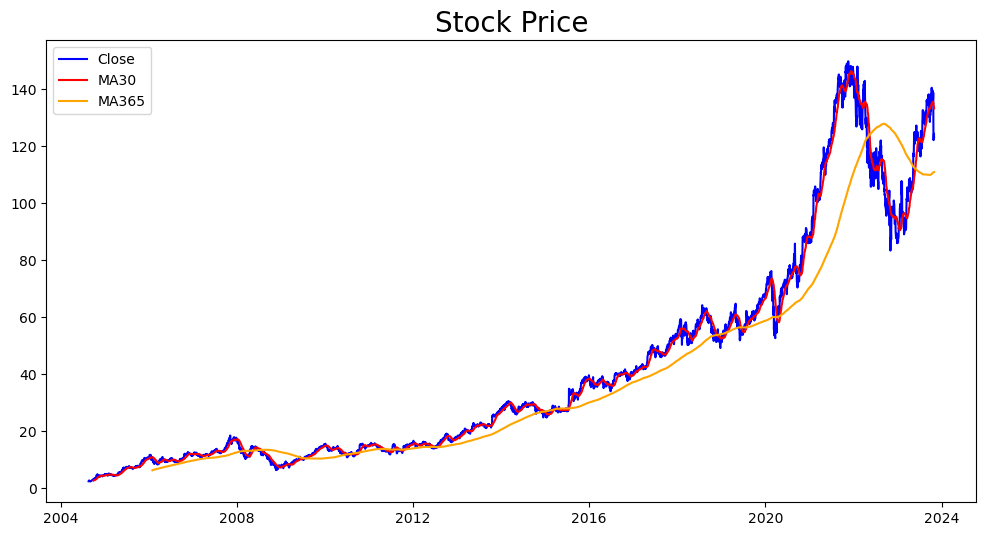

In [232]:
MA30 = Data.Close.rolling(30).mean()
MA365 = Data.Close.rolling(365).mean()
fig, ax = plt.subplots(figsize=(12,6))
plt.title("Stock Price",fontsize= 20)
plt.plot(Data.Close, color="Blue", label="Close")
plt.plot(MA30, color = 'Red', label = "MA30")
plt.plot(MA365, color = 'Orange', label = "MA365")
plt.legend()
plt.show()

In [236]:
Data["Daily Return"] = Data["Close"].pct_change(1)
Data["Daily Return"]

Date
2004-08-19         NaN
2004-08-20    0.079430
2004-08-23    0.010064
2004-08-24   -0.041408
2004-08-25    0.010776
                ...   
2023-10-25   -0.095094
2023-10-26   -0.026511
2023-10-27   -0.000900
2023-10-30    0.018744
2023-10-31   -0.010043
Name: Daily Return, Length: 4834, dtype: float64

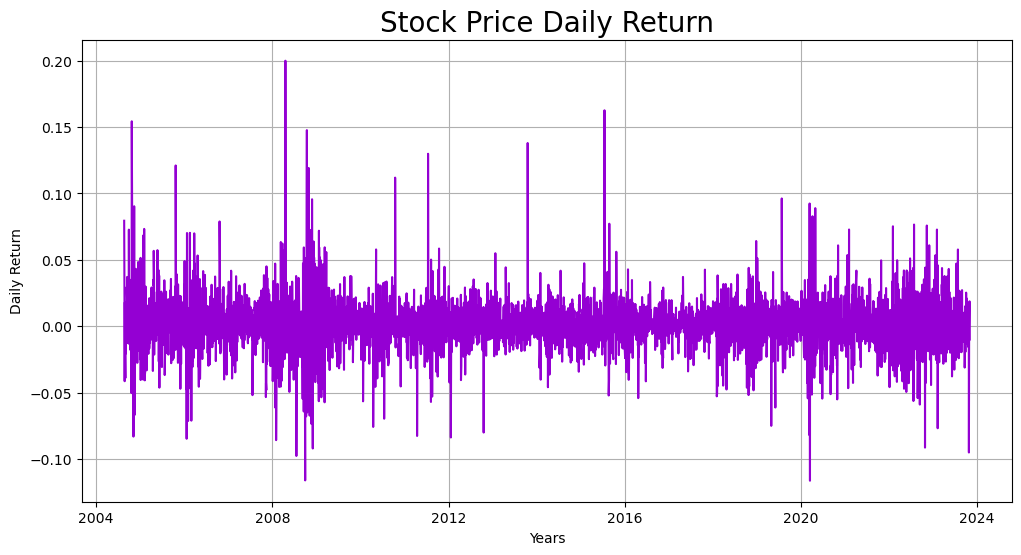

In [237]:
fig, ax = plt.subplots(figsize=(12,6))
plt.title("Stock Price Daily Return",fontsize=20)
ax.plot(Data.index, Data["Daily Return"], color="Darkviolet")
ax.set_ylabel("Daily Return")
ax.set_xlabel('Years')
plt.grid()
plt.show()

In [238]:
Data.iloc[Data["Daily Return"].argmax()]

Open            1.339364e+01
High            1.370621e+01
Low             1.313238e+01
Close           1.349875e+01
Adj Close       1.349875e+01
Volume          7.286946e+08
Daily Return    1.999154e-01
Name: 2008-04-18 00:00:00, dtype: float64

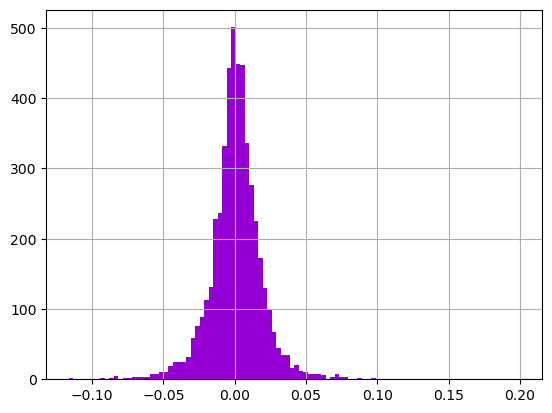

In [239]:
Data["Daily Return"].hist(bins=100, color='Darkviolet')
plt.show()

In [240]:
Data["Cumulative Return"] = (1+Data["Daily Return"]).cumprod()
Data["Cumulative Return"]

Date
2004-08-19          NaN
2004-08-20     1.079430
2004-08-23     1.090293
2004-08-24     1.045146
2004-08-25     1.056408
                ...    
2023-10-25    50.023678
2023-10-26    48.697518
2023-10-27    48.653711
2023-10-30    49.565695
2023-10-31    49.067887
Name: Cumulative Return, Length: 4834, dtype: float64

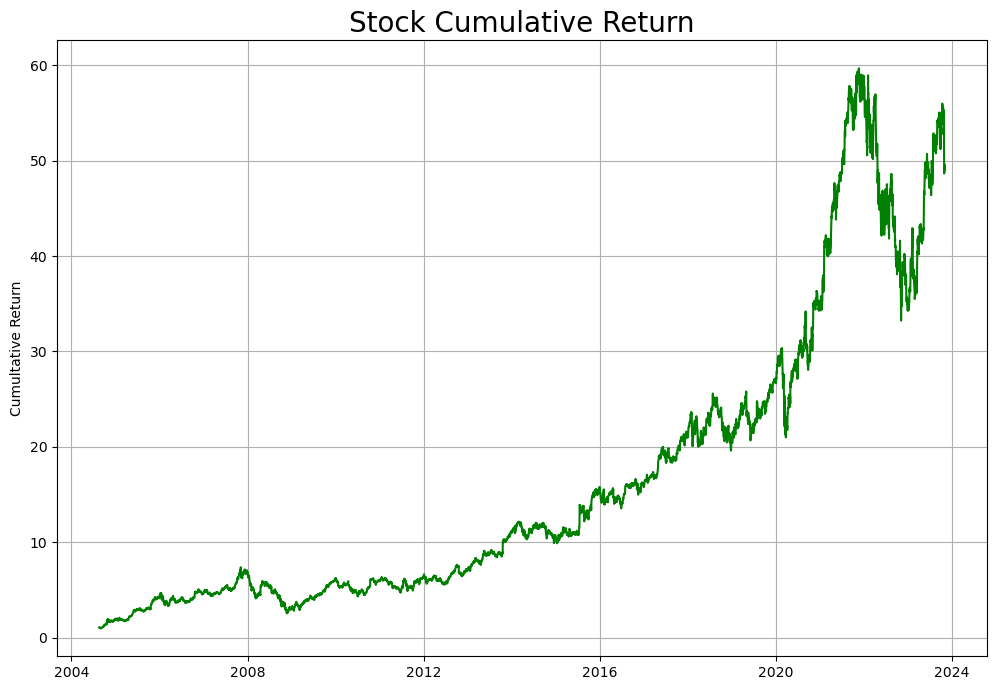

In [241]:
fig, ax = plt.subplots(figsize=(12,8))
plt.title("Stock Cumulative Return",fontsize=20)
ax.plot(Data.index, Data["Cumulative Return"], c='green')
ax.set_ylabel("Cumultative Return")
plt.grid()
plt.show()

In [258]:
tr_length = math.ceil(len(Data.index)*0.85)

In [259]:
scaler = MinMaxScaler(feature_range=(0,1))
PriceData = scaler.fit_transform(Data.Close.values.reshape(-1,1))
PriceData

array([[5.60479451e-05],
       [1.40975243e-03],
       [1.59489383e-03],
       ...,
       [8.12207810e-01],
       [8.27750548e-01],
       [8.19266524e-01]])

In [260]:
X_train, Y_train = [],[]
Backcandles = 60
TrainData = PriceData[0:tr_length]
for i in range(Backcandles,len(TrainData)):
    X_train.append(TrainData[i-Backcandles:i, 0])
    Y_train.append(TrainData[i,0])
    if i<= Backcandles:
        print("X_train:",X_train,"\nY_train:",Y_train)
X_train,Y_train = np.array(X_train), np.array(Y_train)

X_train: [array([5.60479451e-05, 1.40975243e-03, 1.59489383e-03, 8.25467649e-04,
       1.01740387e-03, 1.34181234e-03, 1.04287594e-03, 3.39700452e-04,
       4.00845725e-04, 4.07640543e-05, 2.54772507e-04, 0.00000000e+00,
       2.66663035e-04, 3.88955197e-04, 3.90651070e-04, 9.03602394e-04,
       1.27217637e-03, 1.94987979e-03, 2.03650522e-03, 2.37110835e-03,
       2.96898114e-03, 3.28660289e-03, 3.02843054e-03, 3.12014522e-03,
       3.53458705e-03, 3.36643350e-03, 3.09976400e-03, 4.56048161e-03,
       5.27724673e-03, 5.02586758e-03, 5.53202409e-03, 5.95325265e-03,
       6.51545872e-03, 6.29634647e-03, 6.59698683e-03, 6.40675458e-03,
       5.98722351e-03, 6.35069854e-03, 6.94517797e-03, 7.13201686e-03,
       7.49039457e-03, 8.34814367e-03, 8.14092356e-03, 6.87554039e-03,
       8.38550789e-03, 1.23005578e-02, 1.48432212e-02, 1.38920599e-02,
       1.46003327e-02, 1.58453331e-02, 1.53935351e-02, 1.63090280e-02,
       1.61120026e-02, 1.55684818e-02, 1.43846203e-02, 1.17774199e-

In [261]:
X_train.shape

(4049, 60)

In [262]:
tr_length

4109

In [263]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_train.shape

(4049, 60, 1)

In [284]:
Model = Sequential([
LSTM(50, return_sequences = True, input_shape = (X_train.shape[1], 1)),
(Dropout(0.2)),
LSTM((50)),
(Dropout(0.2)),
(Dense(32)),
(Dense(1))
])

In [285]:
Model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 60, 50)            10400     
                                                                 
 dropout_20 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_21 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_21 (Dropout)        (None, 50)                0         
                                                                 
 dense_20 (Dense)            (None, 32)                1632      
                                                                 
 dense_21 (Dense)            (None, 1)                 33        
                                                                 
Total params: 32,265
Trainable params: 32,265
Non-tra

In [286]:
Model.compile(optimizer="adam", loss="mean_squared_error")
Model.fit(X_train, Y_train, batch_size=32, epochs=10)

Epoch 1/10
127/127 [==============================] - 10s 50ms/step - loss: 0.0022
Epoch 2/10
127/127 [==============================] - 7s 53ms/step - loss: 3.4925e-04
Epoch 3/10
127/127 [==============================] - 9s 70ms/step - loss: 2.9329e-04
Epoch 4/10
127/127 [==============================] - 8s 62ms/step - loss: 2.6055e-04
Epoch 5/10
127/127 [==============================] - 7s 54ms/step - loss: 2.4291e-04
Epoch 6/10
127/127 [==============================] - 6s 48ms/step - loss: 2.3340e-04
Epoch 7/10
127/127 [==============================] - 6s 47ms/step - loss: 2.1387e-04
Epoch 8/10
127/127 [==============================] - 6s 48ms/step - loss: 2.1798e-04
Epoch 9/10
127/127 [==============================] - 6s 48ms/step - loss: 2.0508e-04
Epoch 10/10
127/127 [==============================] - 6s 45ms/step - loss: 1.9212e-04


In [287]:
test_data = PriceData[tr_length-Backcandles:, :]
x_test, y_test = [], Data.Close.values.reshape(-1,1)[tr_length:,:]
for i in range(Backcandles,len(test_data)):
    x_test.append(test_data[i-Backcandles:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
x_test.shape

(725, 60, 1)

In [294]:
from sklearn.metrics import mean_squared_error

In [295]:
pred = Model.predict(x_test)
pred=scaler.inverse_transform(pred)

23/23 [==============================] - 1s 13ms/step


In [370]:
err = mean_squared_error(pred, y_test)
err

17.942665403762206

In [371]:
rmse = err**0.5
rmse

4.235878350916396

In [372]:
Close = Data.filter(['Close'])
TrainingSet,ValidationSet = Close[:tr_length],Close[tr_length:]
ValidationSet["Predictions"] = pred
ValidationSet

,Close,Predictions
Date,,
2020-12-14,87.612999,90.751419
2020-12-15,88.054001,90.530205
2020-12-16,87.859497,90.269035
2020-12-17,87.025497,89.985252
2020-12-18,86.310997,89.650108
...,...,...
2023-10-25,125.610001,139.480209
2023-10-26,122.279999,138.587143
2023-10-27,122.169998,136.986938


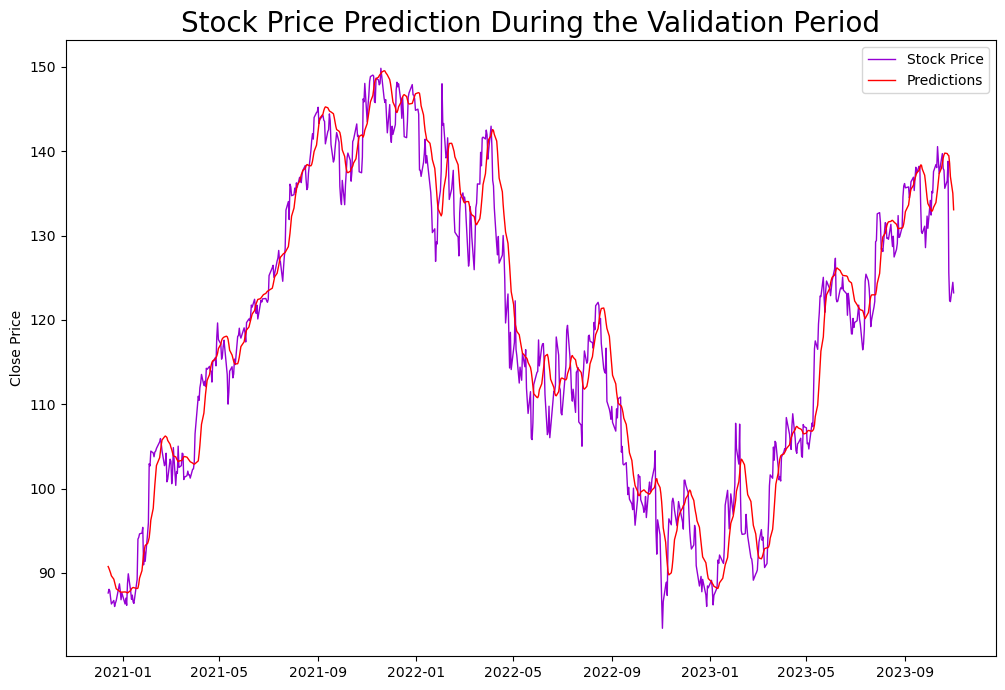

In [373]:
plt.figure(figsize=(12,8))
plt.title("Stock Price Prediction During the Validation Period", fontsize = 20)
plt.ylabel("Close Price")
plt.plot(ValidationSet["Close"],linewidth=1,color = "Darkviolet")
plt.plot(ValidationSet["Predictions"],linewidth=1,color = "Red")
plt.legend(["Stock Price","Predictions"])
plt.show()

In [374]:
temp_data = list(test_data[-60:].flatten())
for i in range(30):
    cur = Model.predict(np.array(temp_data[-60:]).reshape(1,60,1))
    temp_data.append(cur[0,0])

1/1 [==============================] - 0s 23ms/step


In [375]:
len(temp_data)

90

In [376]:
next30 = scaler.inverse_transform(np.array(temp_data[-30:]).reshape(-1,1))

In [377]:
import datetime
from datetime import date, timedelta

current_date = date.today() 
days_after = (date.today()+timedelta(days=29))

print(f'Predictions of stock prices for Google from {current_date} to {days_after}:')
print(next30)

Predictions of stock prices for Google from 2023-11-01 to 2023-11-30:
[[131.17413]
 [129.983  ]
 [129.25798]
 [128.84622]
 [128.64359]
 [128.58015]
 [128.60945]
 [128.70085]
 [128.83418]
 [128.99628]
 [129.17848]
 [129.37517]
 [129.58261]
 [129.79831]
 [130.0205 ]
 [130.2479 ]
 [130.47964]
 [130.71495]
 [130.95335]
 [131.19432]
 [131.43742]
 [131.68237]
 [131.92886]
 [132.1766 ]
 [132.42543]
 [132.67508]
 [132.92545]
 [133.17632]
 [133.42761]
 [133.67924]]


In [378]:
test_date = datetime.datetime.strptime('2023-11-01', '%Y-%m-%d')
dates = pd.date_range(test_date, periods=30)
dates

DatetimeIndex(['2023-11-01', '2023-11-02', '2023-11-03', '2023-11-04',
               '2023-11-05', '2023-11-06', '2023-11-07', '2023-11-08',
               '2023-11-09', '2023-11-10', '2023-11-11', '2023-11-12',
               '2023-11-13', '2023-11-14', '2023-11-15', '2023-11-16',
               '2023-11-17', '2023-11-18', '2023-11-19', '2023-11-20',
               '2023-11-21', '2023-11-22', '2023-11-23', '2023-11-24',
               '2023-11-25', '2023-11-26', '2023-11-27', '2023-11-28',
               '2023-11-29', '2023-11-30'],
              dtype='datetime64[ns]', freq='D')

In [379]:
next_pred = pd.DataFrame(next30.flatten(), dates, columns = ['Predictions'])
next_pred.index.name = 'Date'

In [362]:
next_pred

,Predictions
Date,
2023-11-01,131.174133
2023-11-02,129.983002
2023-11-03,129.257980
2023-11-04,128.846222
2023-11-05,128.643585
2023-11-06,128.580154
2023-11-07,128.609451
2023-11-08,128.700851
2023-11-09,128.834183


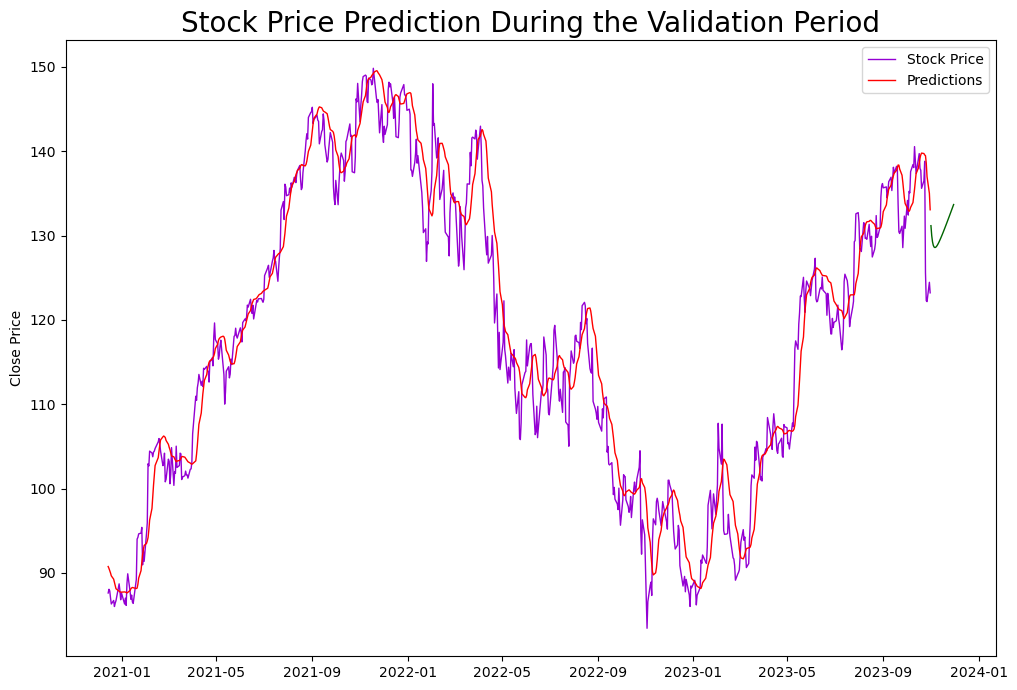

In [380]:
plt.figure(figsize=(12,8))
plt.title("Stock Price Prediction During the Validation Period", fontsize = 20)
plt.ylabel("Close Price")
plt.plot(ValidationSet["Close"],linewidth=1,color = "Darkviolet")
plt.plot(ValidationSet["Predictions"],linewidth=1,color = "Red")
plt.plot(next_pred['Predictions'], linewidth=1, color='Darkgreen')
plt.legend(["Stock Price","Predictions"])
plt.show()